In [ ]:
#!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia
#!unzip chest-xray-covid19-pneumonia.zip

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall,Recall

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Data"



Mounted at /content/drive
densenet_90.h5		       train		       vgg_5size.h5
model_1.h5		       unique_20_sample_test   vgg_60size.h5
model_cnn_noaug_70%.h5	       unique_20_sample_train  vgg_imgaug_94%.h5
model_weights_densenet_85%.h5  unique_5_sample_test    vgg_imgaug.h5
resnet_dropout_model1.h5       unique_5_sample_train   vizgradcam
resnet_samplesize_model1.h5    unique_60_sample_test   xception_main1.h5
resnet_samplesize_model3.h5    unique_60_sample_train  xception_main.h5
test			       vgg_20size.h5


In [ ]:
train_path = "/content/drive/My Drive/Data/train"
test_path = "/content/drive/My Drive/Data/test"

In [ ]:
path = train_path
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224,
                                   rotation_range=140,
                                   brightness_range=[0.2,0.8],
                                   zoom_range=[0.5,1.0],
                                   shear_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_gen = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

## densenet hypo img aug 
> 89% after img aug


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 412s 4s/step - loss: 0.2204 - accuracy: 0.6556 - val_loss: 12.7963 - val_accuracy: 0.2900

Epoch 00001: val_loss improved from inf to 12.79631, saving model to densenet_0dropout.h5
Epoch 2/10
100/100 [==============================] - 249s 2s/step - loss: 0.1764 - accuracy: 0.7312 - val_loss: 1.2668 - val_accuracy: 0.3000

Epoch 00002: val_loss improved from 12.79631 to 1.26679, saving model to densenet_0dropout.h5
Epoch 3/10
100/100 [==============================] - 215s 2s/step - loss: 0.1509 - accuracy: 0.7581 - val_loss: 3.8711 - val_accuracy: 0.2650

Epoch 00003: val_loss did not improve from 1.26679
Epoch 4/10
100/100 [==============================] - 170s 2s/step - loss: 0.1455 - accuracy: 0.8031 - val_loss: 2.2774 - val_accuracy: 0.0375

Epoch 00004: val_loss did not improve from 1.26679
Epoch 5/10
100/100 [==============================] - 166s 2s/step - loss: 0.1399 - accuracy: 0.7994 - val_loss: 0.3613 - val_accuracy: 0

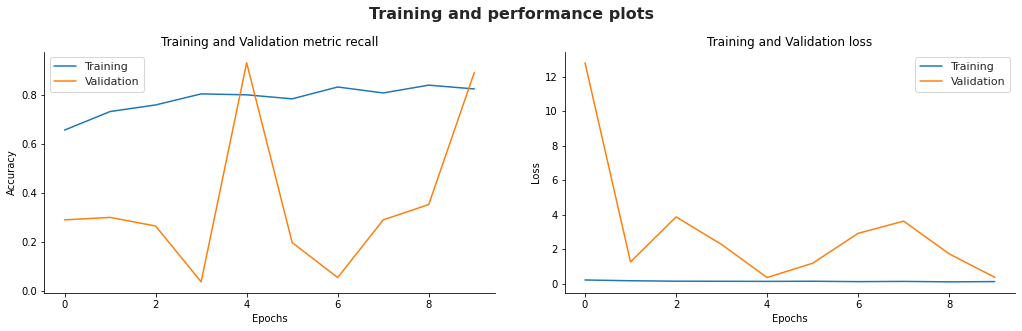

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

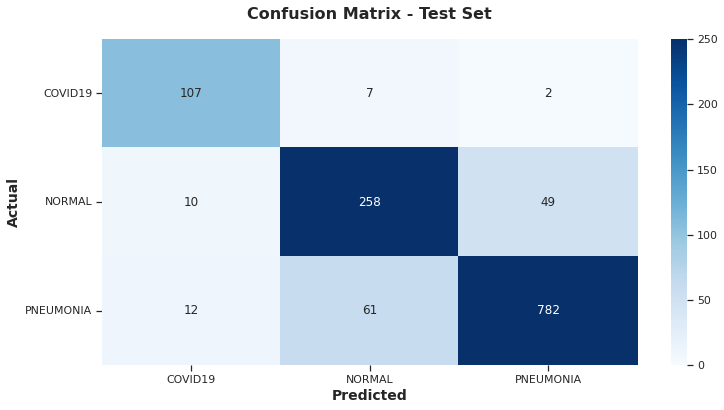

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 39s 467ms/step - loss: 0.3037 - accuracy: 0.8905


[0.30367791652679443, 0.8905279636383057]

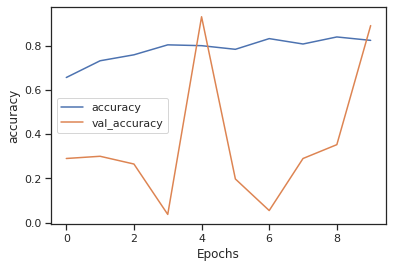

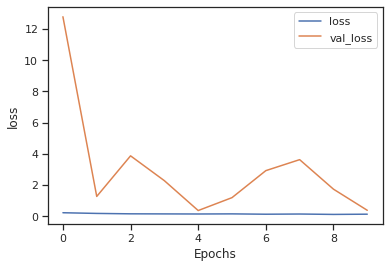

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
model.save("densenet_0dropout.h5.h5")
from google.colab import files
files.download('densenet_0dropout.h5.h5')

model.save("densenet_1dropout.h5.h5")
from google.colab import files
files.download('densenet_1dropout.h5.h5')

model.save("densenet_1dropout.h5.h5")
from google.colab import files
files.download('densenet_1dropout.h5.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

model.save("densenet_2dropout.h5.h5")
files.download('densenet_2dropout.h5.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## densenet no img aug
> 86% before img aug


In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_gen = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 96s 824ms/step - loss: 0.1061 - accuracy: 0.8637 - val_loss: 2.8609 - val_accuracy: 0.7200

Epoch 00001: val_loss improved from inf to 2.86089, saving model to densenet_0dropout.h5
Epoch 2/10
100/100 [==============================] - 78s 776ms/step - loss: 0.0765 - accuracy: 0.9062 - val_loss: 4.3471 - val_accuracy: 0.2075

Epoch 00002: val_loss did not improve from 2.86089
Epoch 3/10
100/100 [==============================] - 77s 771ms/step - loss: 0.0608 - accuracy: 0.9294 - val_loss: 0.1591 - val_accuracy: 0.9475

Epoch 00003: val_loss improved from 2.86089 to 0.15908, saving model to densenet_0dropout.h5
Epoch 4/10
100/100 [==============================] - 78s 781ms/step - loss: 0.0639 - accuracy: 0.9174 - val_loss: 3.1163 - val_accuracy: 0.7100

Epoch 00004: val_loss did not improve from 0.15908
Epoch 5/10
100/100 [==============================] - 78s 777ms/step - loss: 0.0622 - accuracy: 0.9219 - val_loss: 1.1873 - val_accu

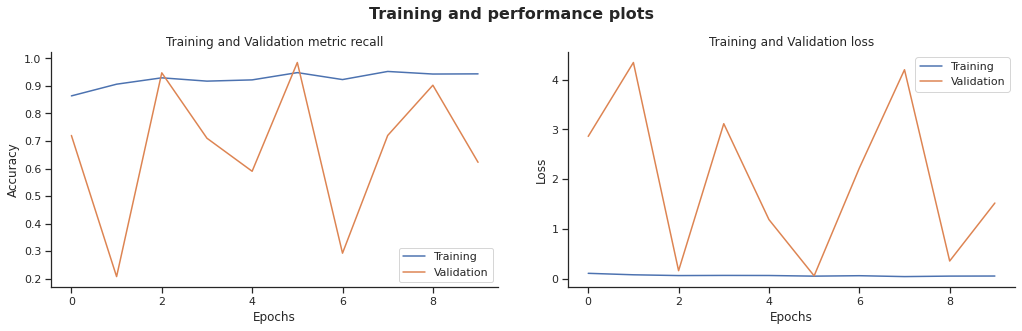

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

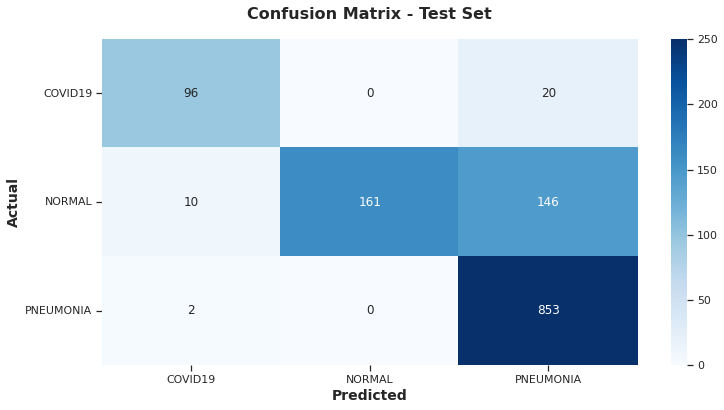

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 466ms/step - loss: 0.5879 - accuracy: 0.8618


[0.5878607034683228, 0.861801266670227]

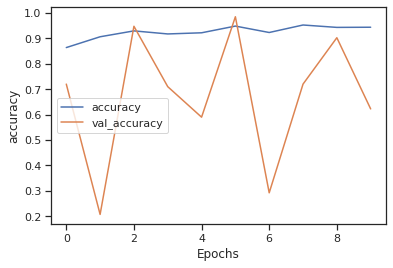

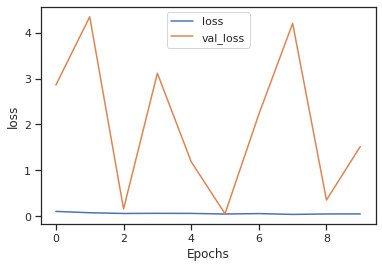

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## densenet hypo img aug: variation
> 87% after img aug variation


In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224,
                                   rotation_range=120,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_gen = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 591s 5s/step - loss: 0.1595 - accuracy: 0.7625 - val_loss: 3.1941 - val_accuracy: 0.1775

Epoch 00001: val_loss improved from inf to 3.19408, saving model to densenet_0dropout.h5
Epoch 2/10
100/100 [==============================] - 331s 3s/step - loss: 0.1302 - accuracy: 0.8075 - val_loss: 4.7137 - val_accuracy: 0.2775

Epoch 00002: val_loss did not improve from 3.19408
Epoch 3/10
100/100 [==============================] - 267s 3s/step - loss: 0.1065 - accuracy: 0.8400 - val_loss: 0.9807 - val_accuracy: 0.6525

Epoch 00003: val_loss improved from 3.19408 to 0.98066, saving model to densenet_0dropout.h5
Epoch 4/10
100/100 [==============================] - 224s 2s/step - loss: 0.1107 - accuracy: 0.8536 - val_loss: 3.3954 - val_accuracy: 0.2900

Epoch 00004: val_loss did not improve from 0.98066
Epoch 5/10
100/100 [==============================] - 188s 2s/step - loss: 

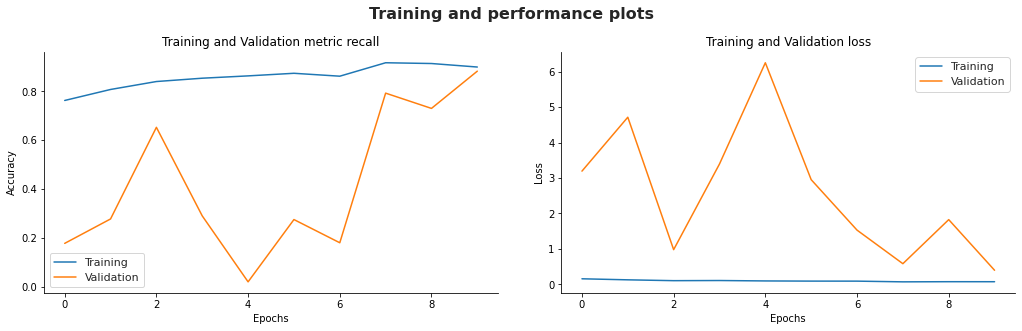

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

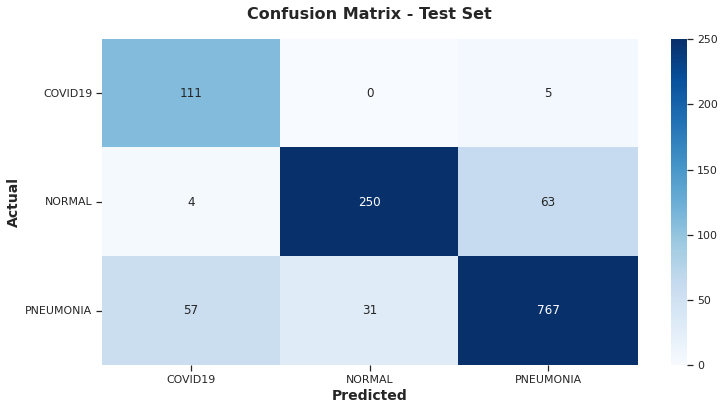

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 37s 451ms/step - loss: 0.3629 - accuracy: 0.8758


[0.3628562390804291, 0.8757764101028442]

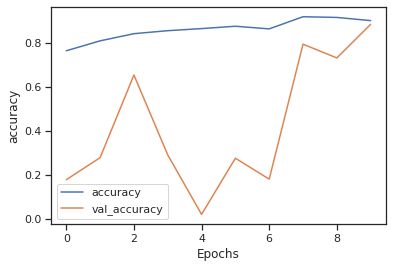

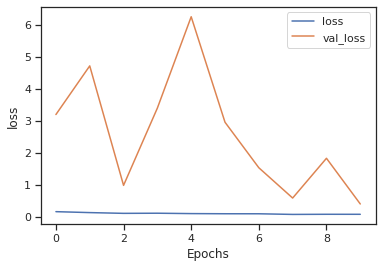

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## Best Model - DenseNet

In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224,
                                   rotation_range=140,
                                   brightness_range=[0.2,0.8],
                                   zoom_range=[0.5,1.0],
                                   shear_range=0.2)


test_datagen = ImageDataGenerator(rescale = 1./224)

train_gen = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_accuracy',save_best_only=True, mode='min',verbose=1)


r = model.fit(
    train_gen, 
    epochs=5,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/5
100/100 [==============================] - 108s 954ms/step - loss: 0.2232 - accuracy: 0.6600 - val_loss: 6.7723 - val_accuracy: 0.0150

Epoch 00001: val_loss improved from inf to 6.77231, saving model to densenet_0dropout.h5
Epoch 2/5
100/100 [==============================] - 93s 929ms/step - loss: 0.1779 - accuracy: 0.7169 - val_loss: 1.6790 - val_accuracy: 0.2975

Epoch 00002: val_loss improved from 6.77231 to 1.67897, saving model to densenet_0dropout.h5
Epoch 3/5
100/100 [==============================] - 93s 930ms/step - loss: 0.1578 - accuracy: 0.7533 - val_loss: 2.9083 - val_accuracy: 0.3825

Epoch 00003: val_loss did not improve from 1.67897
Epoch 4/5
100/100 [==============================] - 93s 929ms/step - loss: 0.1407 - accuracy: 0.7850 - val_loss: 4.1373 - val_accuracy: 0.2900

Epoch 00004: val_loss did not improve from 1.67897
Epoch 5/5
100/100 [==============================] - 93s 932ms/step - loss: 0.1370 - accuracy: 0.7962 - val_loss: 0.6494 - val_accuracy

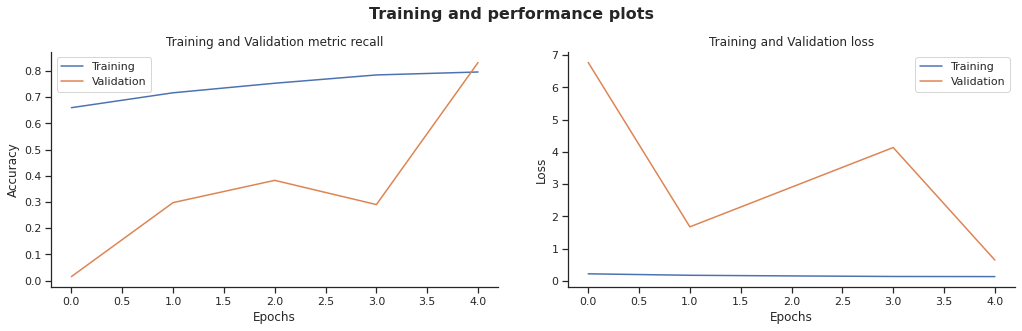

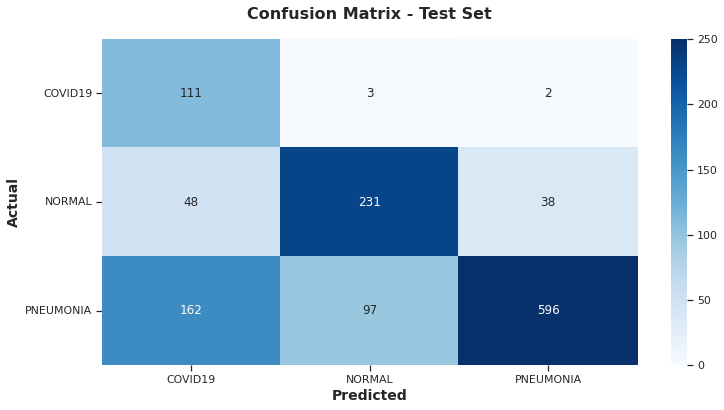

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

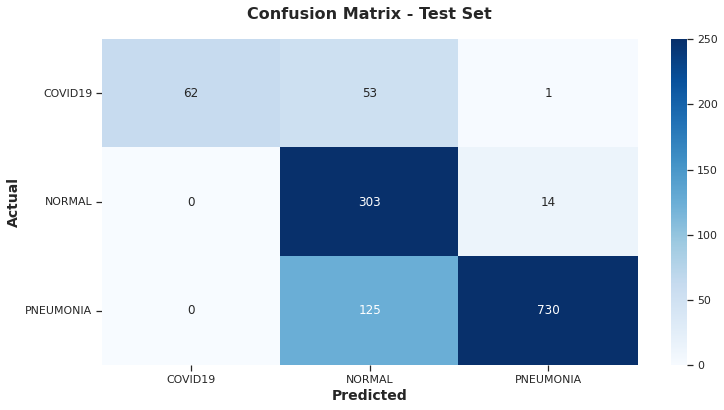

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 456ms/step - loss: 0.2253 - accuracy: 0.9503


[0.22529108822345734, 0.9503105878829956]

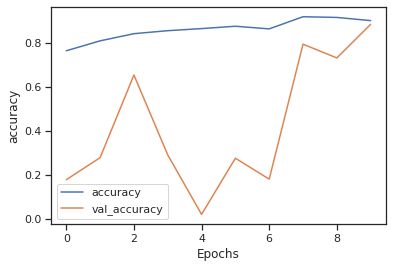

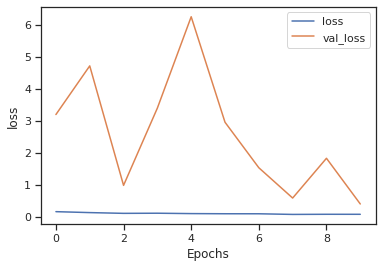

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## Heat Map

In [ ]:
from keras.models import load_model
model = load_model('/content/densenet_0dropout.h5')

In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)



img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_gen = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_accuracy',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=5,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/5
100/100 [==============================] - 634s 6s/step - loss: 0.1026 - accuracy: 0.8506 - val_loss: 4.4115 - val_accuracy: 0.7300

Epoch 00001: val_accuracy improved from inf to 0.73000, saving model to densenet_0dropout.h5
Epoch 2/5
100/100 [==============================] - 353s 4s/step - loss: 0.0781 - accuracy: 0.8944 - val_loss: 10.2874 - val_accuracy: 0.2850

Epoch 00002: val_accuracy improved from 0.73000 to 0.28500, saving model to densenet_0dropout.h5
Epoch 3/5
100/100 [==============================] - 282s 3s/step - loss: 0.0732 - accuracy: 0.9212 - val_loss: 0.7448 - val_accuracy: 0.8575

Epoch 00003: val_accuracy did not improve from 0.28500
Epoch 4/5
100/100 [==============================] - 214s 2s/step - loss: 0.0645 - accuracy: 0.9131 - val_loss: 0.3579 - val_accuracy: 0.8975

Epoch 00004: val_accuracy did not improve from 0.28500
Epoch 5/5
100/100 [==============================] - 177s 2s/step - loss: 0.0481 - accuracy: 0.9457 - val_loss: 0.4458 - val_ac

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

KeyboardInterrupt: ignored

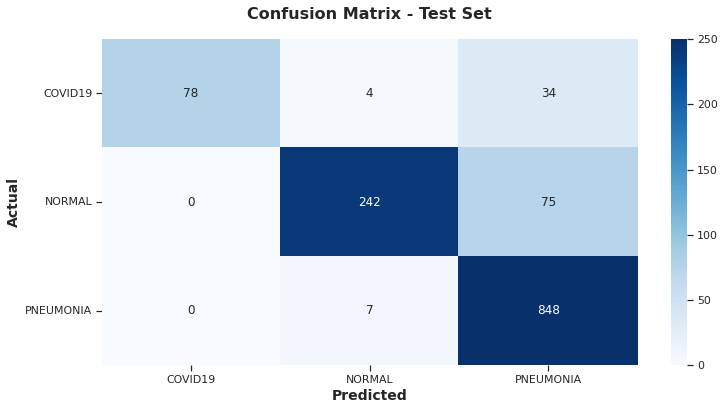

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 37s 444ms/step - loss: 0.5257 - accuracy: 0.8618


[0.5256850719451904, 0.861801266670227]

In [ ]:
model.save("densenet_0dropout.h5")

In [ ]:
from google.colab import files
files.download("densenet_0dropout.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

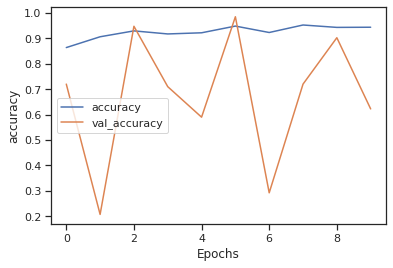

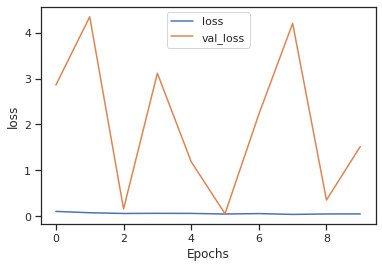

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
#clone from github
!git clone https://github.com/gkeechin/vizgradcam



Cloning into 'vizgradcam'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 32), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (67/67), done.


## heatmap - using pre-trained model

In [ ]:
y_pred = model.predict(test_gen)
y_pred

array([[0.9983386 , 0.00695634, 0.0144546 ],
       [0.9965066 , 0.00204182, 0.04352403],
       [0.98659873, 0.00135627, 0.37794012],
       ...,
       [0.2533476 , 0.02621526, 0.86781275],
       [0.02102455, 0.05641258, 0.9701722 ],
       [0.00331756, 0.11920938, 0.9871467 ]], dtype=float32)

In [ ]:
#cd into the vizgradcam folder downloaded from git
os.chdir("/content/drive/My Drive/Data/vizgradcam")
#!pip install pytorch-gradcam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)

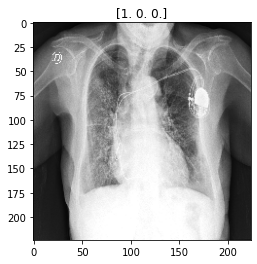

In [ ]:
#an example of how to retrieve an image
test_img = test_gen.__getitem__(1)
preview_imgs, preview_labels = test_img
plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

img = preview_imgs[0]
img.shape




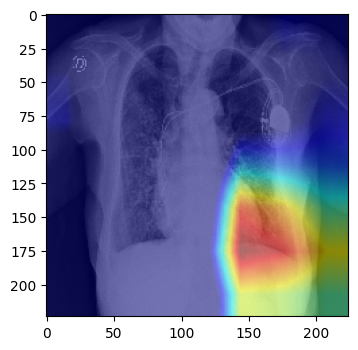

In [ ]:
from gradcam import VizGradCAM

VizGradCAM(
    model,   #load model   (this is your model)
    img
)



In [ ]:
len(test_gen)

81

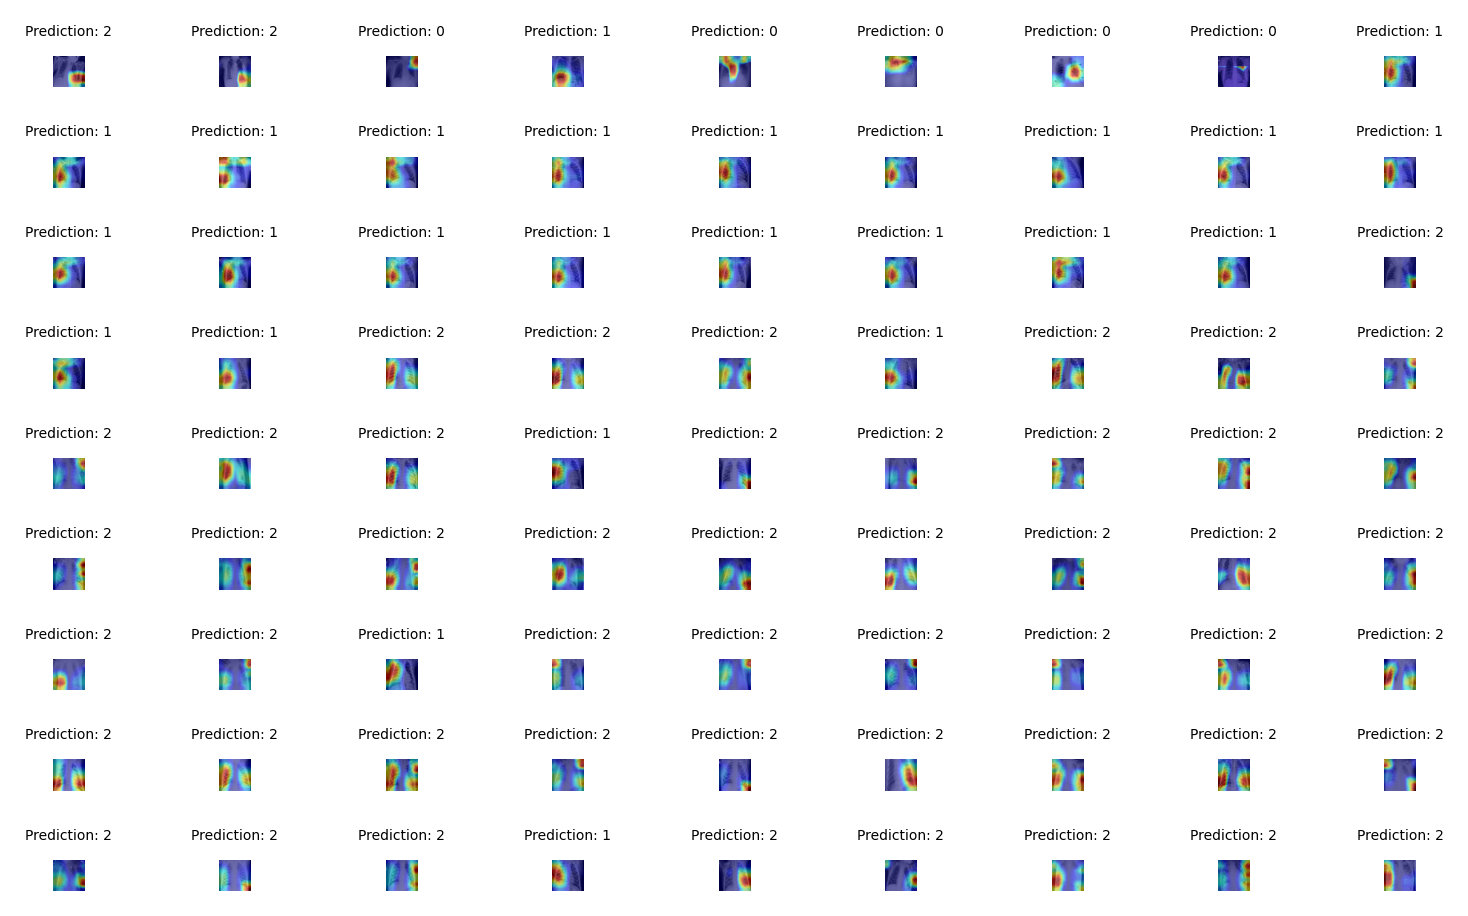

In [ ]:
for i in range(81):
  # define subplot
  plt.rcParams["figure.dpi"] = 250
  plt.subplot(9,9, i+1)
  plt.tight_layout()
  img = test_gen.__getitem__(i)
  preview_img, preview_labels = img
  pred = model.predict(preview_img[0].reshape(1, 224, 224, 3))
  plt.title("Prediction: " + str(pred.argmax()),fontsize = 4)
  plt.axis('off')
  VizGradCAM(model, preview_img[0])

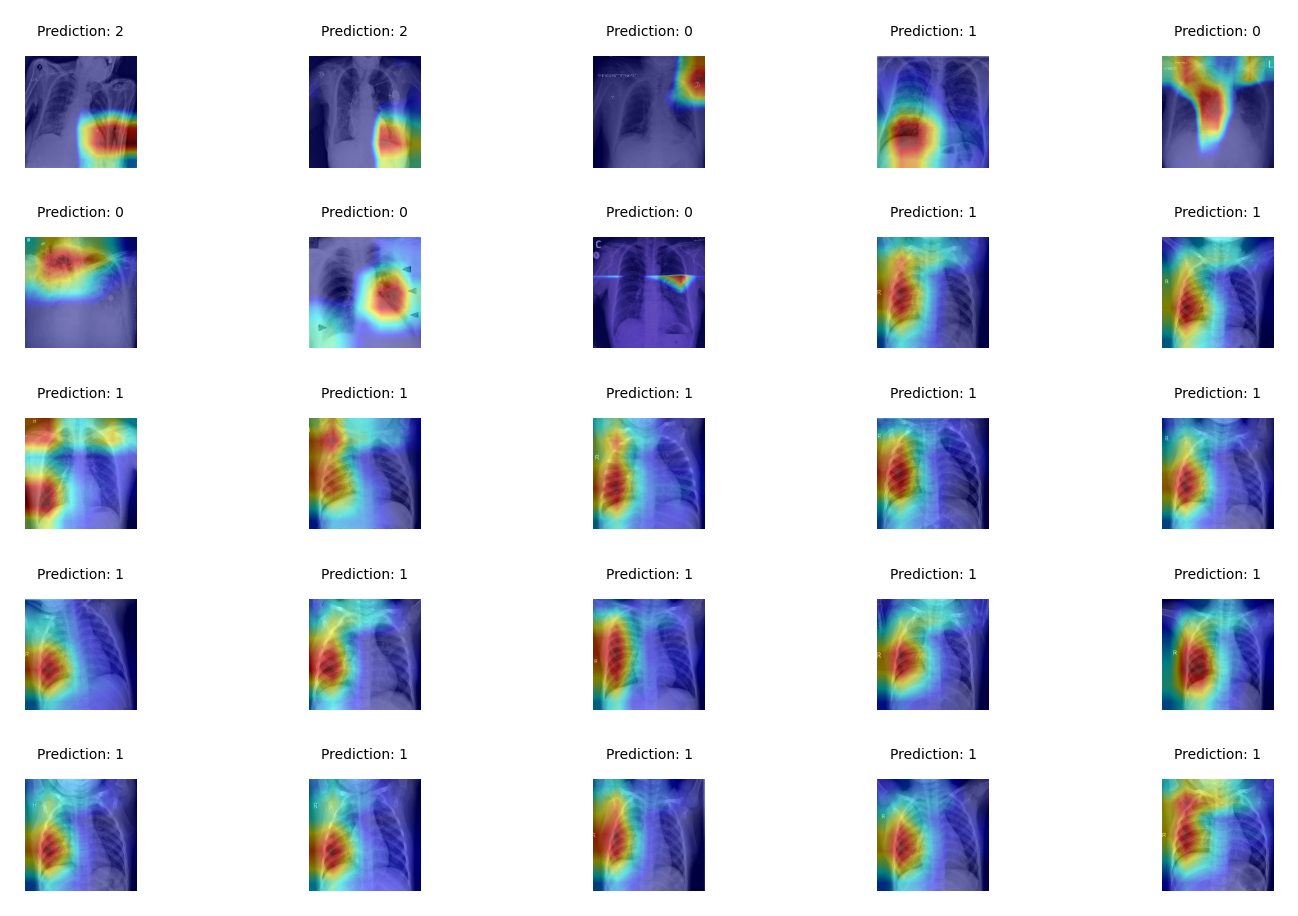

In [ ]:
for i in range(25):
  # define subplot
  plt.rcParams["figure.dpi"] = 250
  plt.subplot(5,5, i+1)
  plt.tight_layout()
  img = test_gen.__getitem__(i)
  preview_img, preview_labels = img
  pred = model.predict(preview_img[0].reshape(1, 224, 224, 3))
  plt.title("Prediction: " + str(pred.argmax()),fontsize = 4)
  plt.axis('off')
  VizGradCAM(model, preview_img[0])